In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7fb1f822cc70>

In [2]:
%config InlineBackend.figure_format = "retina"

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 18

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Load the data from Eric's file

In [17]:
df = pd.read_csv("firas_monopole_spec_v1.txt", skiprows=18, delim_whitespace=True,
                 names=["freq", "intensity", "residual", "uncertainty", "poles_model"])

firas_freq = (df["freq"].values * u.cm**(-1) * const.c).to(u.GHz)
firas_int = df["intensity"].values * u.MJy / u.sr
firas_unc = df["uncertainty"].values * u.kJy / u.sr

# Define the blackbody function

In [18]:
def planck(nu, T, mu=0):
    return (2 * const.h * nu**3 / const.c**2 / (np.exp((const.h * nu - mu) / (const.k_B * T)) - 1)).to(u.MJy) / u.sr

# Plot the data with a 2.725K blackbody

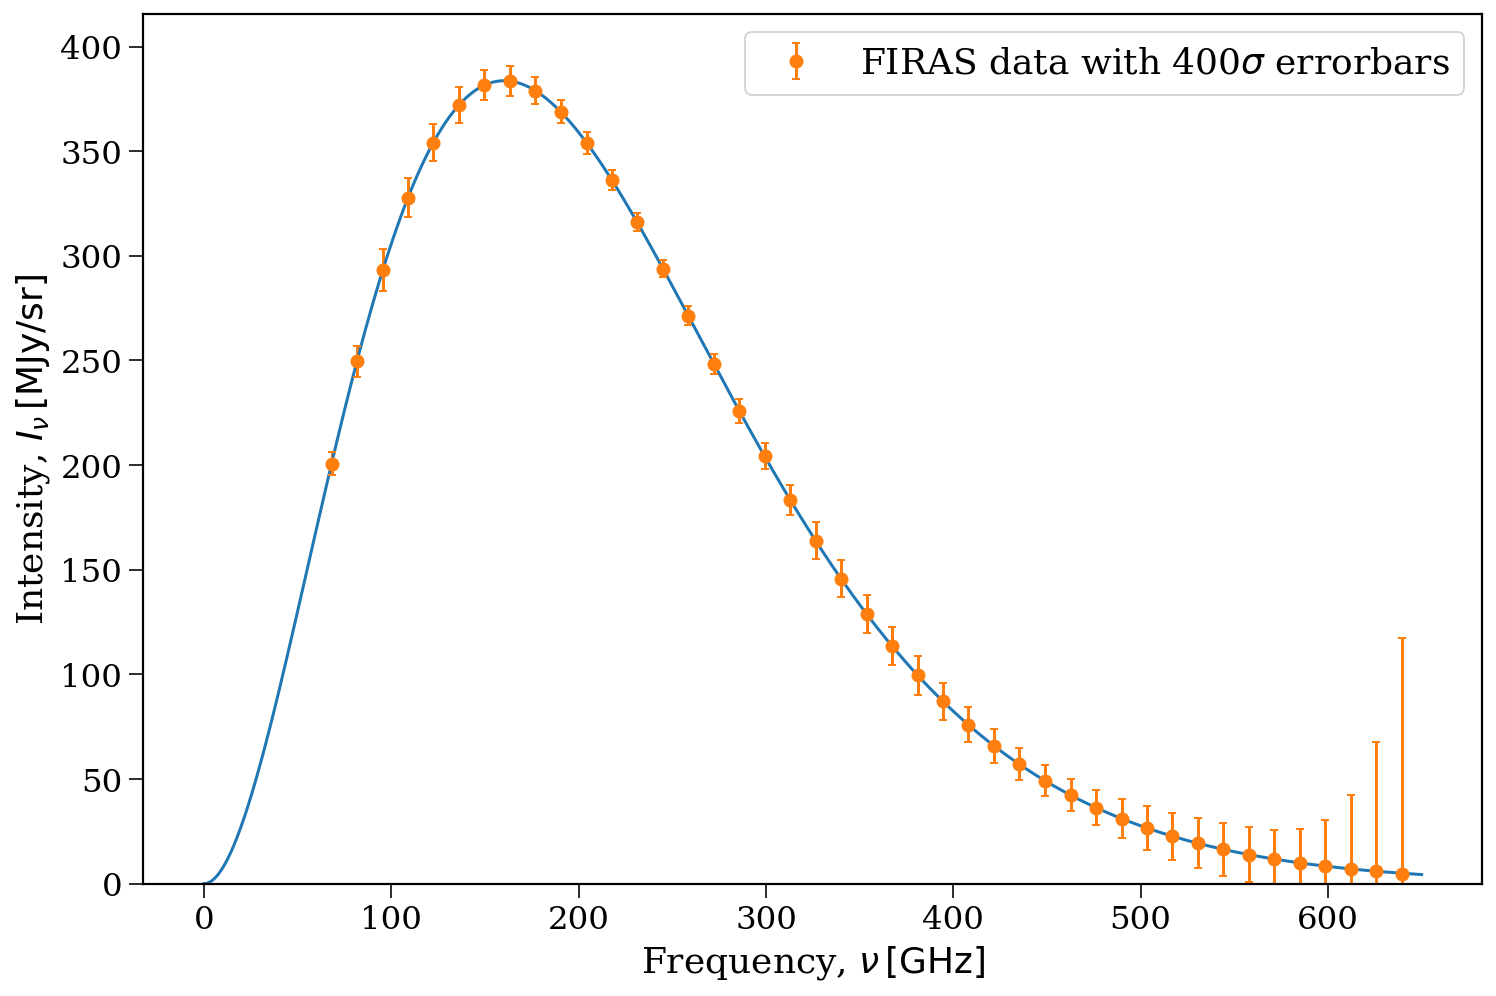

In [19]:
fig, ax = plt.subplots()

nu_range = np.linspace(0.01, 650, 1000) * u.GHz
ax.plot(nu_range, planck(nu_range, 2.725 * u.K))

ax.errorbar(firas_freq, firas_int, yerr=firas_unc * 400,
            marker="o", capsize=2, ls="none", label=r"FIRAS data with 400$\sigma$ errorbars")

ax.legend()

ax.set_xlabel(r"Frequency, $\nu \, [\rm GHz]$")
ax.set_ylabel(r"Intensity, $I_\nu \, [\rm MJy / sr]$")

ax.set_ylim(bottom=0)

plt.show()

In [29]:
def chisquare(freq, measured, uncertainty, T=2.2725 * u.K, mu = 0 * u.erg):
    model = planck(freq, T=T, mu=mu)
    return np.sum( (measured - model)**2 / uncertainty**2 ).decompose().value

In [91]:
T_range = np.linspace(2.7, 2.75, 1000) * u.K

c2 = np.array([chisquare(firas_freq, firas_int, firas_unc, T=T) for T in T_range])

In [103]:
mu_range = np.logspace(-23, np.log10(4.4e-16), 500) * u.erg

c2 = np.array([chisquare(firas_freq, firas_int, firas_unc, mu=mu) for mu in mu_range])

In [75]:
(firas_freq * const.h).to(u.erg).min()

<Quantity 4.5092321e-16 erg>

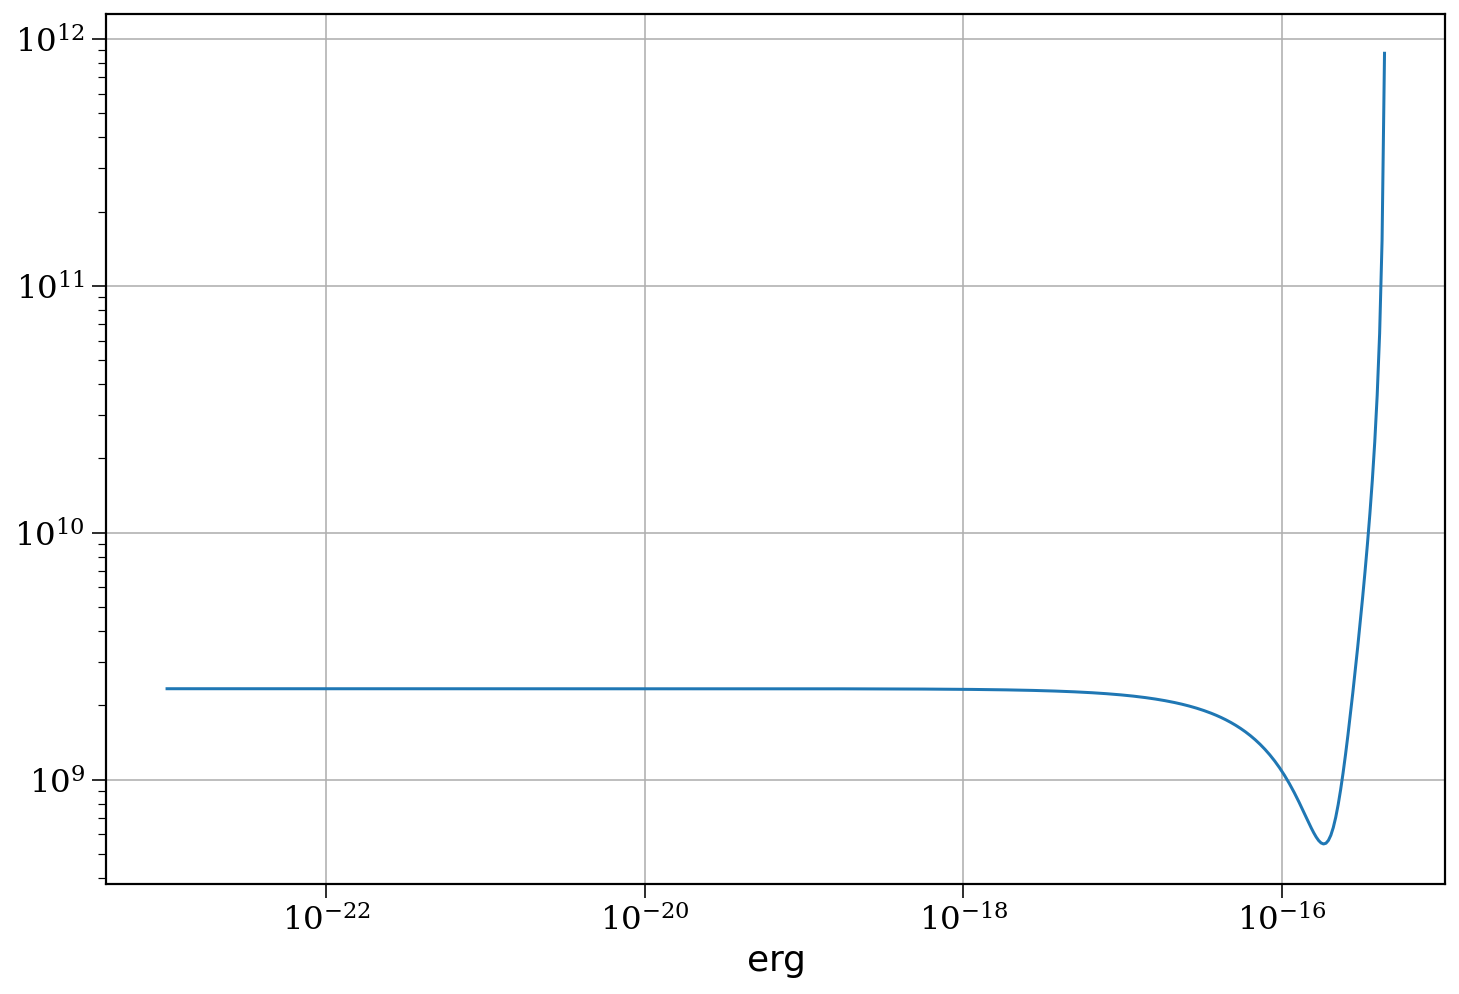

In [104]:
plt.loglog(mu_range, c2)
plt.grid()

In [146]:
T_range = np.linspace(2.7, 2.75, 100) * u.K
mu_range = np.logspace(-19, np.log10(4.4e-16), 99) * u.erg

c2_grid = np.zeros((len(T_range), len(mu_range)))

for i in range(len(T_range)):
    for j in range(len(mu_range)):
        c2_grid[i][j] = chisquare(firas_freq, firas_int, firas_unc, T=T_range[i], mu=mu_range[j])

In [142]:
c2_grid.min()

165.3221397823979

In [123]:
from matplotlib.colors import LogNorm

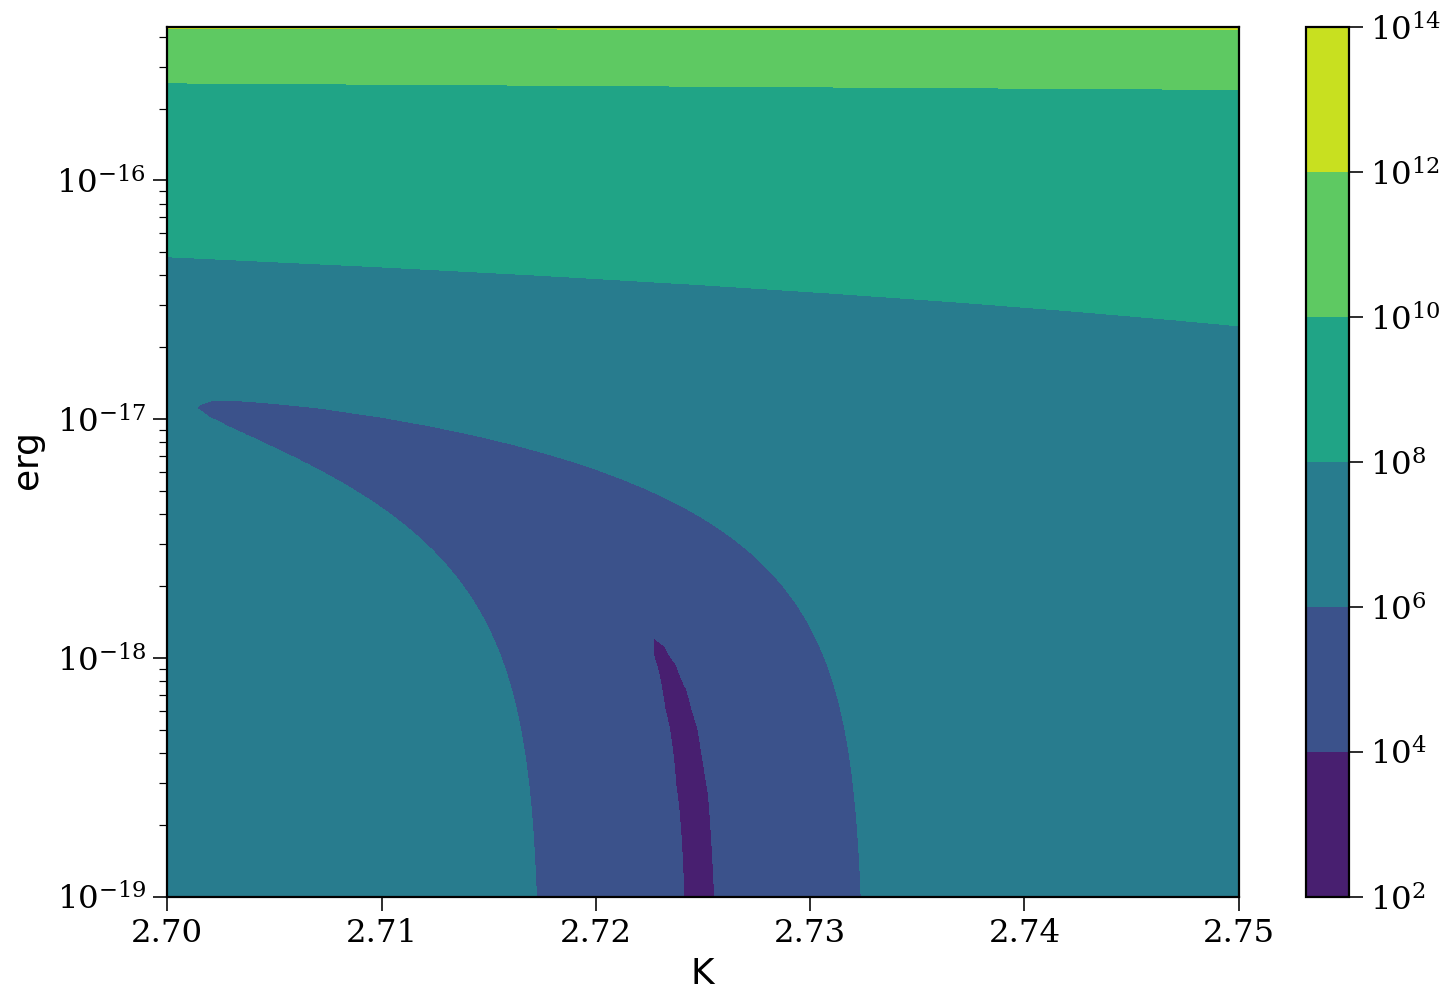

In [147]:
fig, ax = plt.subplots()

cont = ax.contourf(T_range, mu_range, c2_grid.T, cmap="viridis", norm=LogNorm())
fig.colorbar(cont, ax=ax)

ax.set_yscale("log")

plt.show()

In [109]:
c2_grid

array([[10505511.33259815, 10490261.86879528, 10473523.45765158, ...,
         2055712.20760042,  1689372.96882882,  1389647.14344855],
       [10086961.47102269, 10072010.88459423, 10055600.82749105, ...,
         1893038.88123356,  1553069.30885583,  1282492.25698823],
       [ 9676737.6469116 ,  9662086.41784672,  9646005.24209599, ...,
         1739097.69151341,  1425539.10819564,  1184156.39750237],
       ...,
       [10382505.71449124, 10398538.07506108, 10416166.569773  , ...,
        28690487.70352127, 31079146.75521196, 33824236.91599195],
       [10825846.22299588, 10842225.78871943, 10860235.72993658, ...,
        29430582.52744979, 31849769.62367849, 34628593.87784125],
       [11278653.9258994 , 11295381.21377848, 11313773.16947374, ...,
        30180581.74079397, 32630341.34426193, 35442948.7170124 ]])

In [13]:
T_range = np.linspace(2.7, 2.75, 100) * u.K
mu_range = np.logspace(-19, -17, 50) * u.erg

TEMP, MU = np.meshgrid(T_range, mu_range)

In [10]:
np.array([TEMP.flatten(), MU.flatten()]).T.shape

(50000, 2)

In [11]:
model_values = planck(firas_freq[:, None], T=TEMP.flatten()[None, :], mu=MU.flatten()[None, :])

In [165]:


c2 = [chisquare((df["freq"].values * u.cm**(-1) * const.c).to(u.GHz), df["intensity"].values * u.MJy / u.sr, df["uncertainty"].values * u.kJy / u.sr,
                T=T, mu=1e-17*u.erg) for T in T_range]

In [145]:
T_range[np.argmin(c2)]

<Quantity 2.72502503 K>

In [149]:
c2[np.argmin(c2)] - c2[np.argmin(c2) + 1]

<Quantity -1.63437951>

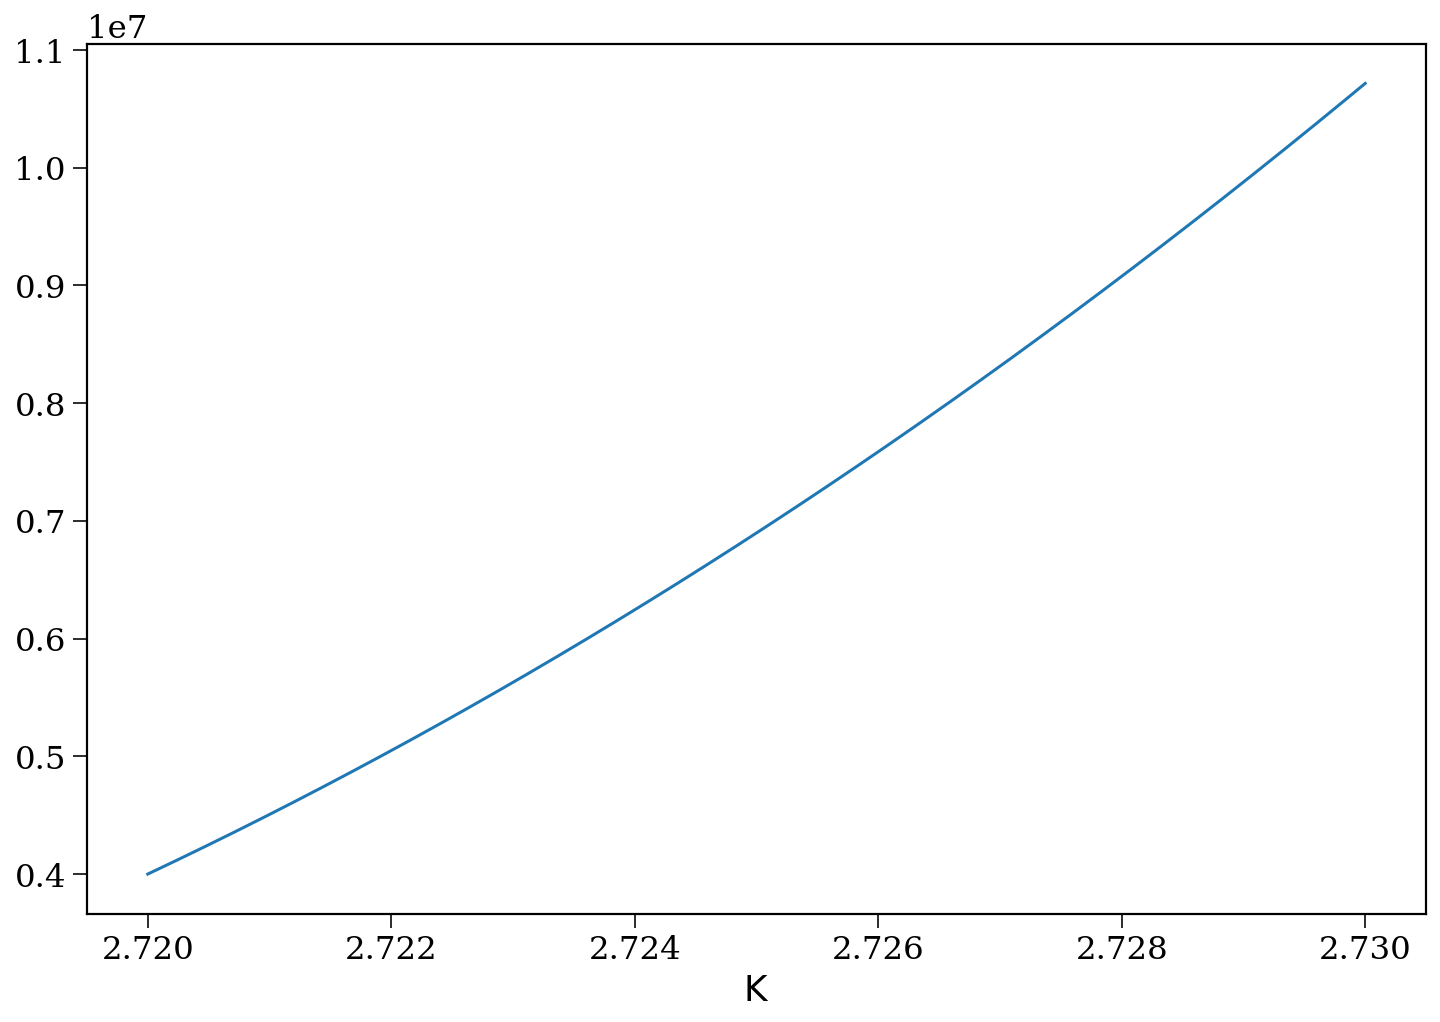

In [163]:
plt.plot(T_range, c2)